## Deep Research Experiment with `LangGraph`

This notebook aims to test multi-round research with back-and-forth between an OpenAI LLM and Perplexity. Orchestrated with `LangGraph`.



In [101]:
import os

from dotenv import load_dotenv
load_dotenv()

from IPython.display import display, Markdown, Image
from langchain_core.messages import BaseMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.constants import Send
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages
import operator

from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, List, Dict

### Prompts

In [22]:
system_message_content = """You are a helpful assistant that can help with research."""
system_message = SystemMessage(content=system_message_content)

### research question writer

user_message_template = """
A user requires help with their research question. They have provided a topic they are interested in and the reason for their interest. Additionally, they have provided some background on themselves to help you understand their perspective.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>


Your task is to write research questions that can be submitted to Perplexity or Google Scholar for further research. Return a list of research questions.
"""

### answer writer prompt

answer_writer_template = """
You are assisting a user with their research. The topic is:

<topic>
{topic}
</topic>

The question you need to answer is:
<question>
{question}
</question>

Provide a detailed answer to the question.
"""

### Structured Outputs

In [5]:
class ResearchQuestion(BaseModel):
    question: str = Field(description="A research question that can be submitted to Perplexity or Google Scholar for further research.")

class ResearchQuestions(BaseModel):
    questions: List[ResearchQuestion] = Field(description="A list of research questions that can be submitted to Perplexity or Google Scholar for further research.")

### LLMs

In [49]:
question_writer_model = "gpt-4o-2024-11-20"
question_writer_llm = ChatOpenAI(
    model=question_writer_model, 
    temperature=0.0
    )
question_writer_llm = question_writer_llm.with_structured_output(ResearchQuestions, method="json_schema", include_raw=True)

answer_writer_model = "llama-3.1-sonar-large-128k-online"
answer_writer_llm = ChatOpenAI(
    model=answer_writer_model, 
    temperature=0.0, 
    base_url="https://api.perplexity.ai", 
    api_key=os.getenv('PPLX_API_KEY')
    )

Test question writer

In [18]:
topic = "The impact of AI on the job market"
reason = "I am interested in the impact of AI on the job market because I am a software engineer and I want to understand how AI is changing the job market."
background = "I am a software engineer and I have been working in the tech industry for 10 years."

user_message = user_message_template.format(topic=topic, reason=reason, background=background)

test_response = question_writer_llm.invoke([system_message] + [user_message])

In [20]:
test_response.questions

[ResearchQuestion(question='What are the current trends in the adoption of AI technologies in the job market?'),
 ResearchQuestion(question='How is AI impacting the demand for software engineering roles in the tech industry?'),
 ResearchQuestion(question='What are the potential long-term effects of AI on employment across various industries?'),
 ResearchQuestion(question='How can software engineers adapt their skills to remain competitive in an AI-driven job market?'),
 ResearchQuestion(question='What are the ethical considerations of AI replacing human jobs in the workforce?')]

Test answer writer

In [23]:
answer_writer_prompt = answer_writer_template.format(topic=topic, question=test_response.questions[0].question)
test_answer = answer_writer_llm.invoke([system_message] + [answer_writer_prompt])

In [28]:
print(test_answer.content[:1000])

The current trends in the adoption of AI technologies in the job market are multifaceted and indicate a significant shift towards increased integration and demand for AI skills. Here are some key points highlighting these trends:

## Growing Demand for AI Skills
There is a pronounced increase in the demand for workers with AI skills across various industries. Both tech and non-tech firms are driving this demand, with a particular focus on roles such as machine-learning specialists, natural language processing experts, and those who can implement and integrate AI tools into business operations[1][2][5].

## Rebound in Tech Industry Hiring
After several slow years, the tech industry is showing signs of a hiring rebound, with AI-related jobs being a significant part of this resurgence. This includes not only roles in AI development but also positions that involve the implementation and management of AI tools within existing workflows[1][2].

## Increased Adoption Across Sectors
AI adoptio

### Build the graph

In [102]:
class AgentState(TypedDict):

    topic: str
    reason: str
    background: str

    messages: Annotated[Sequence[BaseMessage], add_messages]

    questions: List[str]
    question: str
    questions_with_answers: Annotated[List[Dict[str, str]], operator.add]

In [103]:
def write_questions(state: AgentState) -> AgentState:

    user_message = user_message_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background']
        )
    
    response = question_writer_llm.invoke([system_message] + [user_message])

    response_parsed = response["parsed"]
    response_raw = response["raw"]
    response_raw.name = 'Question Writer'
    
    questions = [question.question for question in response_parsed.questions]
    
    return {
        'questions': questions,
        'messages': [system_message] + [user_message] + [response_raw]
        }

def answer_question(state: AgentState) -> AgentState:

    print(f'Answering question: {state["question"]}')

    user_message = answer_writer_template.format(
        topic=state['topic'], 
        question=state['question']
        )
    
    response = answer_writer_llm.invoke([system_message] + [user_message])
    response.name = 'Answer Writer'

    return {
        'messages': [response],
        'questions_with_answers': [{'question': state['question'], 'answer': response.content}]
        }

def send_questions_to_answer_writer(state: AgentState) -> AgentState:

    return [Send("answer_question", {"question": q, "topic": state['topic']}) for q in state['questions']]


In [104]:
workflow = StateGraph(AgentState)

workflow.add_node("write_questions", write_questions)
workflow.add_node("answer_question", answer_question)

workflow.add_edge(START, "write_questions")
workflow.add_conditional_edges("write_questions", send_questions_to_answer_writer, ["answer_question"])
workflow.add_edge("answer_question", END)

app = workflow.compile()

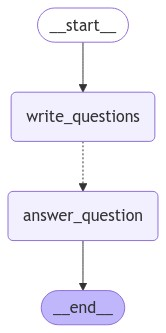

In [105]:
display(Image(app.get_graph().draw_mermaid_png()))

In [106]:
test = app.invoke({"topic": topic, "reason": reason, "background": background})

Answering question: How is AI impacting the demand for software engineering roles in the tech industry?
Answering question: What are the potential long-term effects of AI on employment across various industries?

Answering question: What are the current trends in the adoption of AI technologies in the job market?


Answering question: How can software engineers adapt their skills to remain competitive in an AI-driven job market?

Answering question: What are the ethical considerations of AI replacing human jobs in the workforce?



In [107]:
test

{'topic': 'The impact of AI on the job market',
 'reason': 'I am interested in the impact of AI on the job market because I am a software engineer and I want to understand how AI is changing the job market.',
 'background': 'I am a software engineer and I have been working in the tech industry for 10 years.',
 'messages': [SystemMessage(content='You are a helpful assistant that can help with research.', id='2efb145b-3ea1-462e-96c0-d1495db4c45c'),
  HumanMessage(content='\nA user requires help with their research question. They have provided a topic they are interested in and the reason for their interest. Additionally, they have provided some background on themselves to help you understand their perspective.\n\n<topic>\nThe impact of AI on the job market\n</topic>\n\n<reason>\nI am interested in the impact of AI on the job market because I am a software engineer and I want to understand how AI is changing the job market.\n</reason>\n\n<background>\nI am a software engineer and I have b